In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import run_ring_sim_variable_cfm
print('Libraries imported.')

Libraries imported.


In [3]:
from attack_param_sweep_single_lane import make_benign_driver_list_single_lane

driver_controller_list = make_benign_driver_list_single_lane()

print('Driver control list defined.')

Driver control list defined.


In [5]:
sim_res_list = run_ring_sim_variable_cfm(ring_length=600,
    driver_controller_list=driver_controller_list,
    num_lanes=1,
    sim_time=500,
    want_render=False,
    emission_path='data')

print('Simulation finished.')

Number of classes of driver: 40
Running ring simulation, ring length: 600


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 2686.6650126993964
data/ring_variable_cfm_20220621-1248551655833735.6505978-0_emission.csv data
Average, std velocities: 6.2299619242315725, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 2686.6650126993964, 0.0
Total time: 46.0136501789093
steps/second: 124.00772962457496
Simulation finished.


In [12]:
import csv

def get_sim_timeseries(csv_path,warmup_period=0.0):
    row_num = 1
    curr_veh_id = 'id'
    sim_dict = {}
    curr_veh_data = []

    with open(csv_path, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        id_index = 0
        time_index = 0
        speed_index = 0
        headway_index = 0
        relvel_index = 0
        edge_index = 0

        row1 = next(csvreader)
        num_entries = len(row1)
        while(row1[id_index]!='id' and id_index<num_entries):id_index +=1
        while(row1[edge_index]!='edge_id' and edge_index<num_entries):edge_index +=1
        while(row1[time_index]!='time' and time_index<num_entries):time_index +=1
        while(row1[speed_index]!='speed' and speed_index<num_entries):speed_index +=1
        while(row1[headway_index]!='headway' and headway_index<num_entries):headway_index +=1
        while(row1[relvel_index]!='leader_rel_speed' and relvel_index<num_entries):relvel_index +=1

        for row in csvreader:
            if(row_num > 1):
                # Don't read header
                if(curr_veh_id != row[id_index]):
                    #Add in new data to the dictionary:

                    #Store old data:
                    if(len(curr_veh_data)>0):
                        sim_dict[curr_veh_id] = np.array(curr_veh_data).astype(float)
                    #Rest where data is being stashed:
                    curr_veh_data = []
                    curr_veh_id = row[id_index] # Set new veh id
                    #Allocate space for storing:
                    # sim_dict[curr_veh_id] = []

                curr_veh_id = row[id_index]
                sim_time = float(row[time_index])
                edge = row[edge_index]
                if(sim_time > warmup_period):
                    # data = [time,speed,headway,leader_rel_speed]
                    data = [row[time_index],row[speed_index],row[headway_index],row[relvel_index]]
                    curr_veh_data.append(data)
            row_num += 1

        #Add the very last vehicle's information:
        sim_dict[curr_veh_id] = np.array(curr_veh_data).astype(float)
        
    print('Data loaded.')
    return sim_dict

In [13]:
warmup_period = 100.0
csv_path = sim_res_list[1]     
timeseries_dict = get_sim_timeseries(csv_path,warmup_period=warmup_period)
print('Simulation data extracted.')

Data loaded.
Simulation data extracted.


In [31]:
def bando_ovm_accel(v,s,v_l,p):
    Vm = p[0]
    s0 = p[1]
    s1 = p[2]
    a = p[3]
    b = p[4]
        
    v_opt = Vm*((np.tanh(s/s0-s1)+np.tanh(s1))/(1+np.tanh(s1)))
    ftl = (v_l-v)/(s**2)
    u = a*(v_opt-v) + b*ftl
    
    return u

def sim_bando(v0,s0,v_l_vals,p,dt):
    num_steps = len(v_l_vals)
    v_vals = np.zeros_like(v_l_vals)
    s_vals = np.zeros_like(v_l_vals)
    v_vals[0] = v0
    s_vals[0] = s0
    
    for i in range(1,num_steps):
        v = v_vals[i-1]
        s = s_vals[i-1]
        v_l = v_l_vals[i-1]
        dv_dt = bando_ovm_accel(v,s,v_l,p)
        ds_dt = v_l -v
        v_new = v + dv_dt*dt
        s_new = s + ds_dt*dt
        
        v_vals[i] = v_new
        s_vals[i] = s_new
        
    return v_vals,s_vals

def spacing_rmse(s_vals_real,s_vals_sim):
    error = s_vals_real - s_vals_sim
    squared_error = np.multiply(error,error)
    return np.sqrt(np.mean(squared_error))

def get_spacing_rmse(v_vals_real,s_vals_real,v_l_vals,p,dt):
    v0 = v_vals_real[0]
    s0 = s_vals_real[0]
    v_vals_sim,s_vals_sim = sim_bando(v0,s0,v_l_vals,p,dt)
    return spacing_rmse(s_vals_real,s_vals_sim)

def get_timeseries_dict_mean_spacing_rmse(timeseries_dict,p,dt):
    
    spacing_rmse_vals = []
    
    for veh_id in timeseries_dict:
        v_vals_real = timeseries_dict[veh_id][:,1]
        s_vals_real = timeseries_dict[veh_id][:,2]
        v_l_vals = v_vals_real + timeseries_dict[veh_id][:,3]
        rmse = get_spacing_rmse(v_vals_real,s_vals_real,v_l_vals,p,dt)
        spacing_rmse_vals.append(rmse)
        
    mean_spacing_rmse = np.mean(spacing_rmse_vals)
    
    return mean_spacing_rmse
    
print('Defined model calibration functions.')

Defined model calibration functions.


In [33]:
mean_spacing_rmse =  get_timeseries_dict_mean_spacing_rmse(timeseries_dict,p=p_init,dt=0.1)
print(p_init)

[15.0, 2.0, 2.0, 0.8, 20.0]


In [34]:
from scipy.optimize import minimize

p_init = [15.0, 2.0, 2.0, 0.8, 20.0]

def obj_func(p):
    return get_timeseries_dict_mean_spacing_rmse(timeseries_dict,p,dt=0.1)

res = minimize(obj_func, p_init, method='BFGS',options={'gtol': 1e-6, 'disp': True})

print('Finished.')

Optimization terminated successfully.
         Current function value: 3.257266
         Iterations: 54
         Function evaluations: 490
         Gradient evaluations: 70
Finished.


In [37]:
p_opt = res.x #[ 8.86655756  2.09865379  3.01753401  0.67993545 25.1010223 ]

In [41]:
def sliding_window_spacing_error(v_vals_real,s_vals_real,v_l_vals,p,seq_len,dt):
    num_time_samples = len(v_vals_real)
    spacing_rmse_vals = []
    
    num_evals = num_time_samples-seq_len
    
    for i in range(num_evals):
        rmse = get_spacing_rmse(v_vals_real[i:i+seq_len],s_vals_real[i:i+seq_len],v_l_vals[i:i+seq_len],p,dt)
        spacing_rmse_vals.append(rmse)
        
    return spacing_rmse_vals

def get_rec_error_timeseries_dict(timeseries_dict,seq_len,p,dt):
    reconstruction_losses = {}
    
    for veh_id in timeseries_dict:
        v_vals_real = timeseries_dict[veh_id][:,1]
        s_vals_real = timeseries_dict[veh_id][:,2]
        v_l_vals = v_vals_real + timeseries_dict[veh_id][:,3]
        
        rec_errors = sliding_window_spacing_error(v_vals_real,s_vals_real,v_l_vals,p,seq_len,dt)
        
        reconstruction_losses[veh_id] = np.array(rec_errors)
        
    return reconstruction_losses
        
print('Defined sliding window reconstruction analysis.')

Defined sliding window reconstruction analysis.


In [44]:
import time

seq_len = 200
dt = 0.1
p = p_opt

begin_time = time.time()
reconstruction_losses = get_rec_error_timeseries_dict(timeseries_dict,seq_len,p,dt)
print('Total processing time: '+str(time.time()-begin_time))

Total processing time: 167.63924384117126


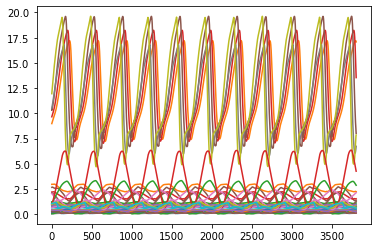

In [43]:
plt.figure()
for veh_id in reconstruction_losses:
    plt.plot(reconstruction_losses[veh_id])


In [50]:
attack_csv_path = '/Volumes/My Passport for Mac/single_lane_ring_road_attack_parameter_sweep/ring_600m_single_lane_TAD_6.0_ADR_-0.75_ver_10.csv'

timeseries_dict_attack = get_sim_timeseries(attack_csv_path,warmup_period=warmup_period)

print('Attack simulation data extracted.')

Data loaded.
Attack simulation data extracted.


Total processing time: 79.9544780254364


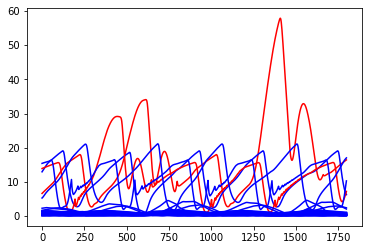

In [51]:
begin_time = time.time()
reconstruction_losses_attack = get_rec_error_timeseries_dict(timeseries_dict_attack,seq_len,p,dt)
print('Total processing time: '+str(time.time()-begin_time))

plt.figure()
for veh_id in reconstruction_losses_attack:
    if('adv' in veh_id):
        plt.plot(reconstruction_losses_attack[veh_id],'r')
    else:
        plt.plot(reconstruction_losses_attack[veh_id],'b')

(0, 60)

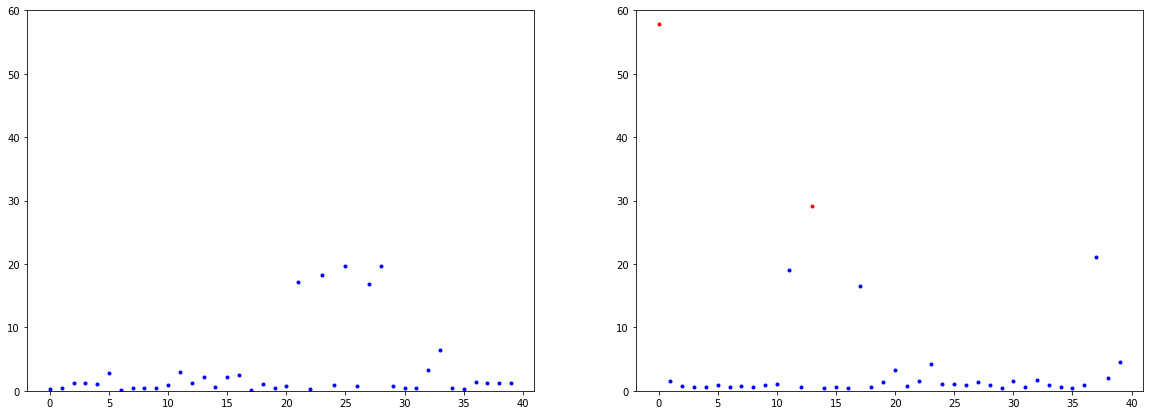

In [55]:
plt.figure(figsize = [20,7])
plt.subplot(1,2,1)
i = 0
for veh_id in reconstruction_losses:
    if('adv' in veh_id):
        plt.plot(i,np.max(reconstruction_losses[veh_id]),'r.')
    else:
        plt.plot(i,np.max(reconstruction_losses[veh_id]),'b.')
    i += 1
plt.ylim([0,60])
plt.subplot(1,2,2)
i = 0
for veh_id in reconstruction_losses_attack:
    if('adv' in veh_id):
        plt.plot(i,np.max(reconstruction_losses_attack[veh_id]),'r.')
    else:
        plt.plot(i,np.max(reconstruction_losses_attack[veh_id]),'b.')
    i += 1
plt.ylim([0,60])    

In [58]:
from Detectors.Model_Based.utils import bando_ovm_accel,get_rec_error_timeseries_dict


def get_and_write_rec_errors(csv_path,rec_error_repo,accel_func,p,seq_len,warmup_period):
    timeseries_dict = get_sim_timeseries(csv_path,warmup_period)
    reconstruction_losses = get_rec_error_timeseries_dict(timeseries_dict,seq_len,accel_func,p,dt)

    i = 0
    while(csv_path[i:i+3]!='TAD'):
        i+=1

    file_name = os.path.join(rec_error_repo,csv_path[i:])

    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        for veh_id in reconstruction_losses:
            losses = reconstruction_losses[veh_id]
            num_samples = len(losses)
            for i in range(num_samples):
                writer.writerow([veh_id,losses[i]])

    return reconstruction_losses

attack_csv_path = '/Volumes/My Passport for Mac/single_lane_ring_road_attack_parameter_sweep/ring_600m_single_lane_TAD_6.0_ADR_-0.75_ver_10.csv'
rec_error_repo = '/Volumes/My Passport for Mac/single_lane_ring_road_attack_parameter_sweep/model_based_rec_errors/'


get_and_write_rec_errors(attack_csv_path,rec_error_repo,bando_ovm_accel,p,seq_len,warmup_period)


Data loaded.


{'RDA_adv_TDA_6.0_ADR_-0.75_k1_1.1_k2_0.32_h_1.71_Vm_16.31_dm_10.0_0': array([ 6.62495221,  6.67590926,  6.72645033, ..., 16.36636732,
        16.40196921, 16.4374254 ]),
 'bando_ftl_ovm_a0.62_b22.1_s02.09_s12.89_Vm8.55_0': array([0.63366993, 0.62974985, 0.62592153, ..., 0.57728822, 0.58365724,
        0.58994095]),
 'bando_ftl_ovm_a0.44_b21.76_s02.45_s12.71_Vm9.27_0': array([0.15814399, 0.15912518, 0.16025464, ..., 0.72635941, 0.72622844,
        0.72611747]),
 'bando_ftl_ovm_a0.53_b22.05_s02.31_s12.75_Vm8.89_0': array([0.18749813, 0.18552083, 0.18308002, ..., 0.45082521, 0.4512753 ,
        0.45161699]),
 'bando_ftl_ovm_a0.65_b21.63_s02.19_s12.8_Vm9.15_0': array([0.47034476, 0.46752355, 0.46455533, ..., 0.39990469, 0.40197693,
        0.40404933]),
 'bando_ftl_ovm_a0.79_b20.63_s02.18_s13.3_Vm8.89_0': array([0.68608257, 0.68958337, 0.69249566, ..., 0.85125982, 0.85259501,
        0.85392161]),
 'bando_ftl_ovm_a0.62_b21.3_s02.28_s12.49_Vm8.68_0': array([0.43478379, 0.43468198, 0.434222

In [72]:
def read_rec_error_csv(csv_path):
    rec_error_dict = {}

    with open(csv_path, 'r', newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        row1 = next(csvreader)
        
        curr_id = row1[0]
        curr_rec_errors = [row1[1]]
        
        for row in csvreader:
            if(row[0] != curr_id):
                rec_error_dict[curr_id] = np.array(curr_rec_errors).astype(float)
                curr_rec_errors = [row[1]]
                curr_id = row[0]
            else:
                curr_rec_errors.append(row[1])
                
        rec_error_dict[curr_id] = np.array(curr_rec_errors).astype(float)
                
    return rec_error_dict

model_based_rec_error_repo = '/Volumes/My Passport for Mac/single_lane_ring_road_attack_parameter_sweep/model_based_rec_errors/'

csv_path = os.path.join(model_based_rec_error_repo,'TAD_6.0_ADR_-0.75_ver_1.csv')

rec_errors_dict = read_rec_error_csv(csv_path = csv_path)

print('rec errors loaded.')


rec errors loaded.


In [78]:
import sys
def get_id(file_name):
    i = 0
    while(file_name[i:i+4] != '_ver'): i+=1
    j = 0
    while(file_name[j:j+3] != 'TAD'): j+=1
    return file_name[j:i]

all_model_based_rec_errors = {}

all_csv_files = os.listdir(model_based_rec_error_repo)

num_files_processed = 0
total_number_files = len(all_csv_files)

for file_name in all_csv_files:
    csv_path = os.path.join(model_based_rec_error_repo,file_name)
    rec_errors_dict = read_rec_error_csv(csv_path = csv_path)
    max_losses = []
    for veh_id in rec_errors_dict:
        is_mal = 'adv' in veh_id
        max_losses.append([is_mal,np.max(rec_errors_dict[veh_id])])
    key = get_id(file_name)
    if(key in all_model_based_rec_errors.keys()):
        all_model_based_rec_errors[key].append(max_losses)
    else:
        all_model_based_rec_errors[key] = [max_losses]
    num_files_processed += 1
    sys.stdout.write('\r'+str(num_files_processed)+'/'+str(total_number_files)+'\r')

print('Finished.')

Finished.


In [82]:
benign_reconstruction_losses = reconstruction_losses

max_benign_loss = 0.0

for veh_id in benign_reconstruction_losses:
    if(np.max(benign_reconstruction_losses[veh_id])>max_benign_loss): max_benign_loss = np.max(benign_reconstruction_losses[veh_id])
        

print(max_benign_loss)

19.622230947463724
